# Analyze DOPE-v1.1 (3k) and RP-v1.1 (3k)
## With pretrained VGG weights
## Wrong map-slicing
In this notebook I try to compare the performance of both DOPE-v1.1 and ResPosev1.1. Both data were trainined on 010_potted_meat_can_16k = 3k images for 60 epochs.
The difference in v1 of both networks is that now they are trained with pretrained weights of VGG.


# Conclusion
In between the two v1.1 models: 
There is probably a bug in ResPose training or with the display.
Some feature maps seem to be learned to locate corner points but not in the same sequence as DOPE.
I need the acutual ground truth generation function/class and display in an additional column.
Also, from now traing on 16 images might be easier to overfit.

In [1]:
import cv2
import matplotlib.pyplot as plt
import torch
from detector import *

## Load Data and Models

In [2]:
## Select epoch number of DOPE and ResPose to comapre
dope_epoch = 60
rp_epoch = 60


# load color image
img_path = 'Dataset/dev/000000.left.jpg'
width,height = 480,640
in_img = cv2.imread(img_path)
in_img = cv2.resize(in_img, (height, width))
in_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB)

# Misc
name = 'meat' # Not useful
gpu_id = 0 # which gpu to use

## DOPE - Select weight
network="DOPE"
net_path = 'weights/dope_meat_v1.1/net_epoch_' + str(dope_epoch) + '.pth'
model = ModelData(name, net_path, gpu_id, network)
model.load_net_model()
dope_model = model.net

# ResPose - Select weight
network="ResPose"
net_path = 'weights/rp_meat_v1.1/net_epoch_' + str(rp_epoch) + '.pth'
model = ModelData(name, net_path, gpu_id, network)
model.load_net_model()
rp_model = model.net

Loading DOPE model 'weights/dope_meat_v1.1/net_epoch_60.pth'...
Training network without imagenet weights.
    Model loaded in 4.9602813720703125 seconds.
Loading DOPE model 'weights/rp_meat_v1.1/net_epoch_60.pth'...
Training network without imagenet weights.
    Model loaded in 4.793213367462158 seconds.


## Define Visualization Functions

In [3]:
# Function for visualizing feature maps
def create_mask(map, threshold=0.9):
    map -= map.min()
    map /= map.max()
    map = map.data.numpy()
    map = cv2.resize(map, (height,width))
    map[map>=threshold] = 1
    map[map<threshold] = 0
    return map

def viz_belief_maps(activations, in_img):
    """
    Given Activations, this will plot belief maps on the left and overlaid image on the right column
    """
    fig, ax = plt.subplots(nrows=9, ncols=2, sharex=True, figsize=(20, 50))
    red = [255,0,0]
    for i, map in enumerate(activations):
        # Create mask out of the belief map
        map = create_mask(map)

        overlaid_img = in_img.copy()
        overlaid_img[map==1,:] = red # Paint red
        
        # Display Thresholded Belief Maps
        ax[i,0].imshow(map, cmap='gray')
        ax[i,0].set_title('Belief %s' % str(i))

        # Display overlayed output image
        ax[i,1].imshow(overlaid_img)
        ax[i,1].set_title('Overlaid %s' % str(i))

def compare_belief_maps(activations_dope, activations_rp, in_img):
    """
    Given dope and ResPose beliefs, this will plot the top-90% thresholded and original 
    image overlaid locations of predicted verticies.
    """
    red = [255,0,0]
    fig, ax = plt.subplots(nrows=9, ncols=2, sharex=True, figsize=(20, 50))
    
    for i, map in enumerate(activations_dope):
        # Create mask out of the belief map
        map = create_mask(map)

        overlaid_img = in_img.copy()
        overlaid_img[map==1,:] = red # Paint red
        
        # Display overlayed output image
        ax[i,0].imshow(overlaid_img)
        ax[i,0].set_title(f'DOPE Belief {i}')
        
    for i, map in enumerate(activations_rp):
        # Create mask out of the belief map
        map = create_mask(map)

        overlaid_img = in_img.copy()
        overlaid_img[map==1,:] = red # Paint red
        
        # Display overlayed output image
        ax[i,1].imshow(overlaid_img)
        ax[i,1].set_title(f'ResPose Belief {i}')

## Belief Maps Comparison
Belief Maps (6th cascade's output) from both the netowrks are compared side by side. The maps are overlaid on top of the original input image. Belief maps are thresholded to display the top 90% predicted locations.

DOPE Epoch: 60
ResPose Epoch: 60


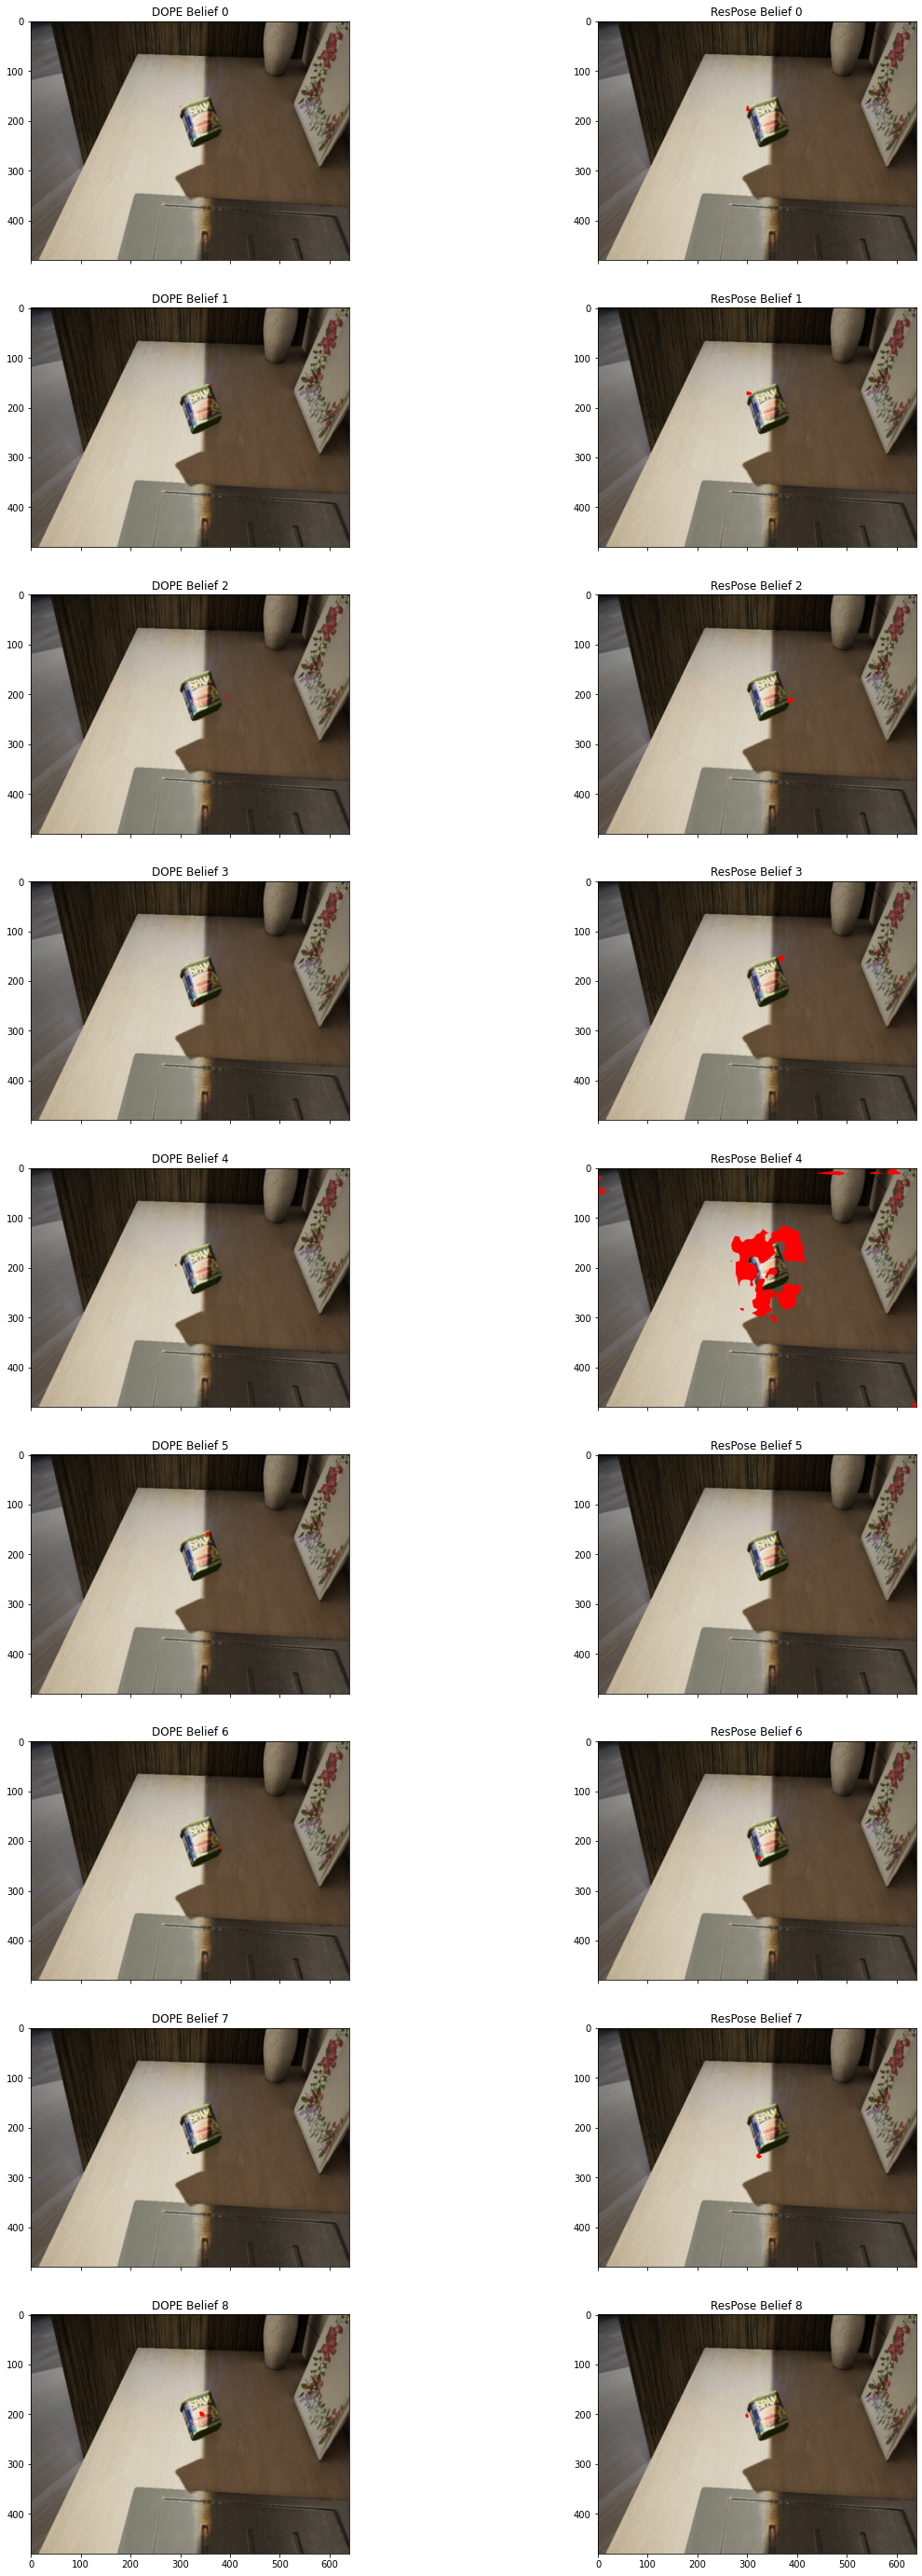

In [4]:
# Run network inference
image_tensor = transform(in_img)
image_torch = Variable(image_tensor).cuda().unsqueeze(0)

out, seg = dope_model(image_torch)
beliefs_dope = out[-1][0].cpu() # Select the last cascade's output only

out, seg = rp_model(image_torch)
beliefs_rp = out[-1][0].cpu() # Select the last cascade's output only


compare_belief_maps(beliefs_dope, beliefs_rp, in_img)
print(f"DOPE Epoch: {dope_epoch}")
print(f"ResPose Epoch: {rp_epoch}")

## ResPose-v1 Thresholded (90%) Belief Maps

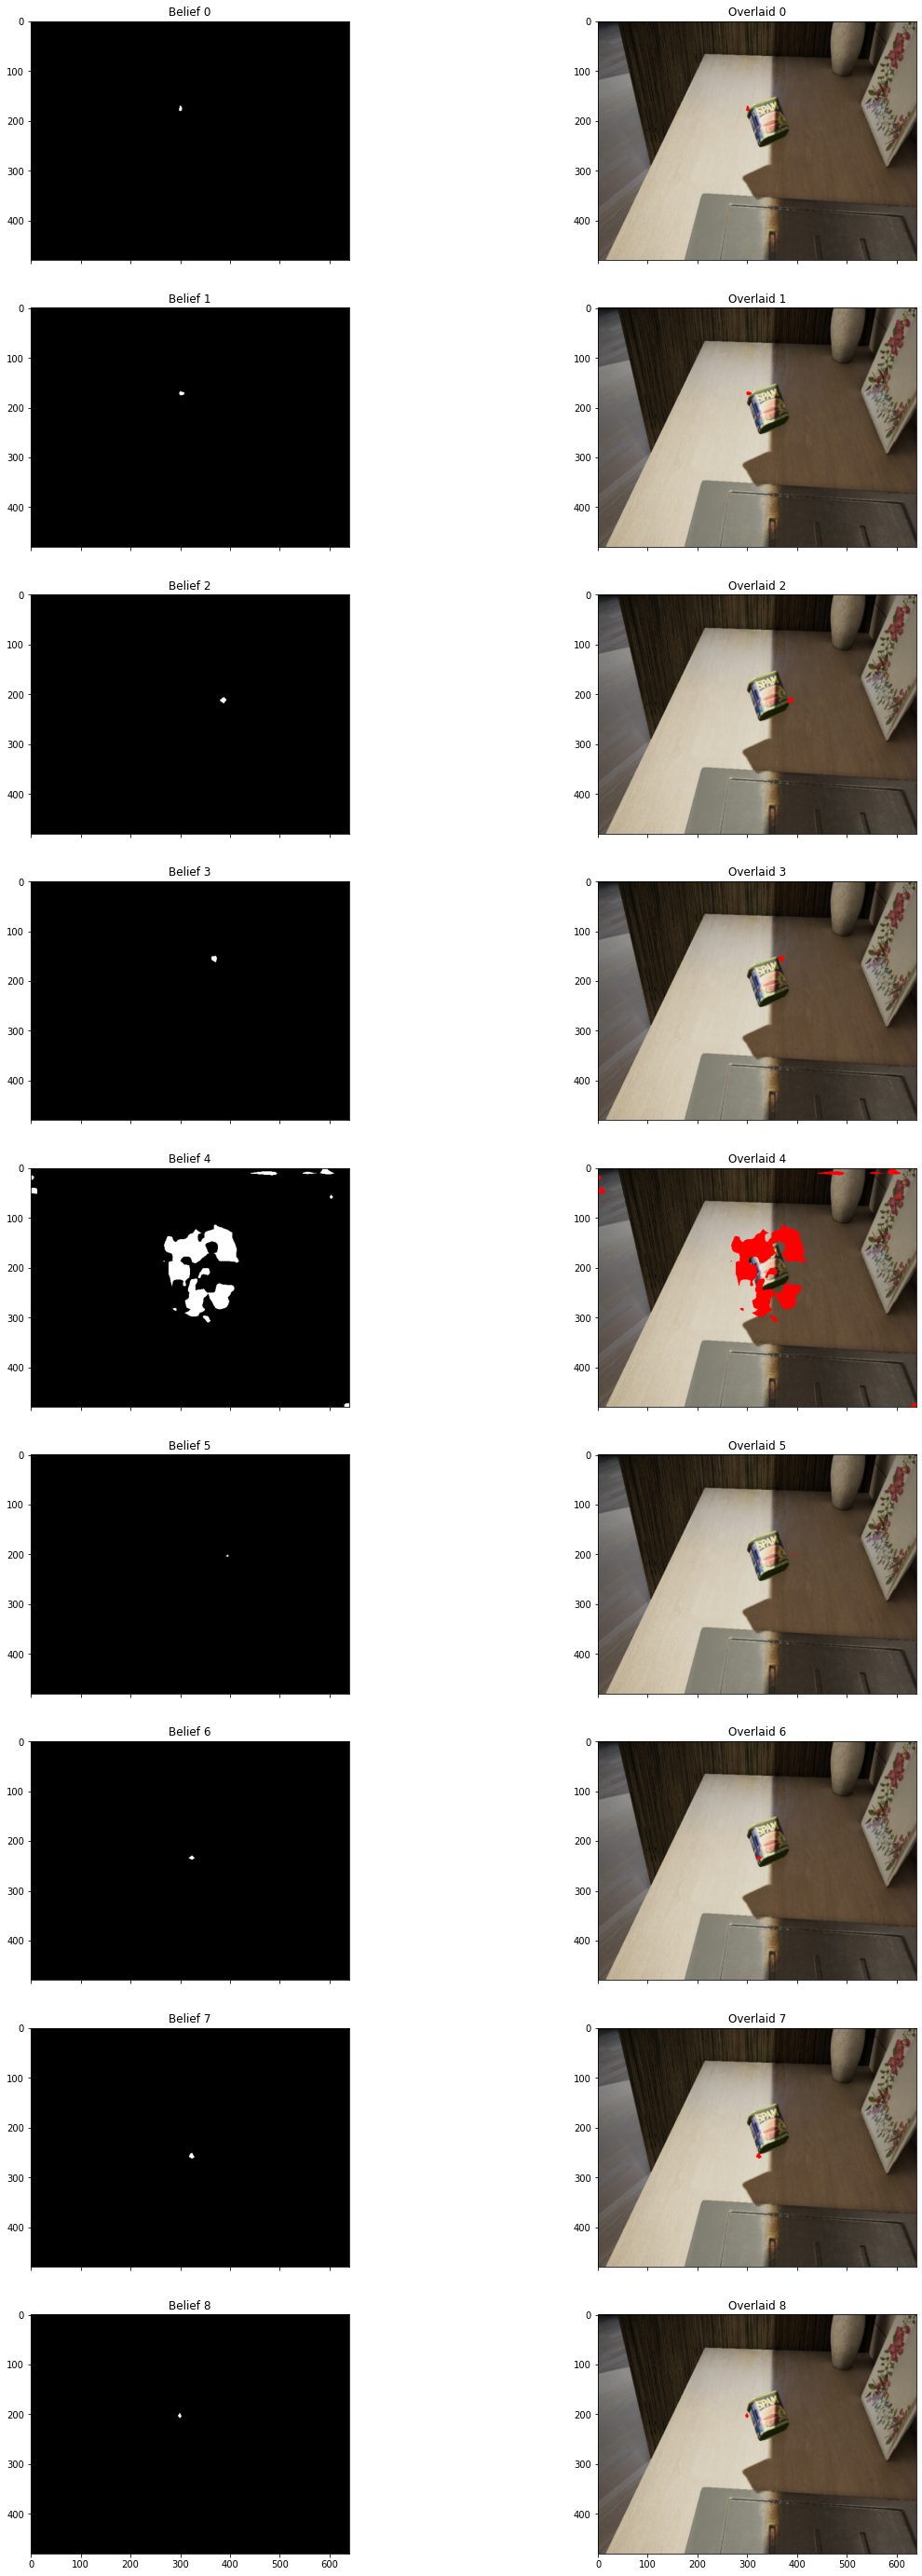

In [5]:
out, seg = rp_model(image_torch)
beliefs = out[-1][0].cpu() # Select the last cascade's output only
affinities = seg[-1][0].cpu() # Select the last cascade's output only
viz_belief_maps(beliefs, in_img)